In [ ]:
!pip install jsonformer

In [1]:
# fix jsonformer
def apply_generate_array_fix(jsonformer):
    def generate_array(item_schema, obj) -> list:
        for _ in range(jsonformer.max_array_length):
            # forces array to have at least one element
            element = jsonformer.generate_value(item_schema, obj)
            obj[-1] = element

            obj.append(jsonformer.generation_marker)
            input_prompt = jsonformer.get_prompt()
            obj.pop()
            input_tensor = jsonformer.tokenizer.encode(input_prompt, return_tensors="pt")
            output = jsonformer.model.forward(input_tensor.to(jsonformer.model.device))
            logits = output.logits[0, -1]


            top_indices = logits.topk(30).indices
            sorted_token_ids = top_indices[logits[top_indices].argsort(descending=True)]

            found_comma = False
            found_close_bracket = False
            for token_id in sorted_token_ids:
                decoded_token = jsonformer.tokenizer.decode(token_id)
                if '{' in decoded_token:
                    found_comma = True
                    break
                if ']' in decoded_token:
                    found_close_bracket = True
                    break

            if found_close_bracket or not found_comma:
                break

        return obj

    def get_prompt():
        template = """{prompt}{progress}"""
        progress = json.dumps(jsonformer.value)
        gen_marker_index = progress.find(f'"{jsonformer.generation_marker}"')
        if gen_marker_index != -1:
            progress = progress[:gen_marker_index]
        else:
            raise ValueError("Failed to find generation marker")

        prompt = template.format(
            prompt=jsonformer.prompt,
            #schema=json.dumps(jsonformer.json_schema),
            progress=progress,
        )

        return prompt
    jsonformer.get_prompt = get_prompt
    jsonformer.generate_array = generate_array
    return jsonformer

In [2]:
import argparse
import torch
from starcoder_finetune.dialogues import DialogueTemplate, get_dialogue_template
from transformers import (AutoModelForCausalLM, AutoTokenizer,
                          GenerationConfig, set_seed)
from jsonformer import Jsonformer

def initialize_model(model_id):
    revision = None
    system_prompt = None
    set_seed(42)
    
    try:
        dialogue_template = DialogueTemplate.from_pretrained(model_id, revision=revision)
    except Exception:
        print("No dialogue template found in model repo. Defaulting to the `no_system` template.")
        dialogue_template = get_dialogue_template("no_system")

    tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)
    tokenizer.eos_token_id = tokenizer.convert_tokens_to_ids(dialogue_template.end_token)
    tokenizer.eos_token_id = tokenizer.eos_token_id
    generation_config = GenerationConfig(
        temperature=float(0.01),
        top_k=50,
        top_p=0.95,
        repetition_penalty=1.2,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.convert_tokens_to_ids(dialogue_template.end_token),
        min_new_tokens=32,
        max_new_tokens=512,
    )
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = AutoModelForCausalLM.from_pretrained(
        model_id, revision=revision, load_in_8bit=True, device_map="auto", torch_dtype=torch.float16
    )
    
    return model, tokenizer, dialogue_template

2023-08-31 14:09:50.171333: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 14:09:50.226255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 14:09:51.733089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def generate_response_as_json_starcoder(prompt_text):
    prompt =[
        {
            "role": "user",
            "content": prompt_text,
        }
    ]
    dialogue_template.messages = [prompt] if isinstance(prompt, dict) else prompt
    formatted_prompt = dialogue_template.get_inference_prompt()

    src_table, src_cols, trg_table, trg_cols = get_enums_from_prompt_text(prompt_text)
    
    json_schema_fk = {
            "type": "object",
            "properties": {
                      "table": { 
                          "type": "enum",
                          "values": [src_table]
                      },
                      "column": { 
                        "type": "enum",
                        "values": src_cols
                      },
                      "referencedTable": { 
                          "type": "enum",
                          "values": [trg_table]
                      },
                      "referencedColumn": { 
                        "type": "enum",
                        "values": trg_cols
                      },
                    },
            "required": ["table", "column", "referencedTable", "referencedColumn"],
    }
    

    jsonformer = Jsonformer(model, tokenizer, json_schema_fk, formatted_prompt, debug = False)
    apply_generate_array_fix(jsonformer)
    result_json = jsonformer()
    
    return result_json

In [ ]:
# generate predictions

In [4]:
import json
prompts_ground_truth_spider = json.load(open(f"prompts_ground_truth_spider.json"))
prompts_ground_truth_bird = json.load(open(f"prompts_ground_truth_bird.json"))
prompts_ground_truth_ctu = json.load(open(f"prompts_ground_truth_ctu.json"))

In [5]:
def get_enums_from_prompt_text(prompt_text):
    src = prompt_text.split("\n")[1]
    trg = prompt_text.split("\n")[2]
    src_table = src[:src.find("(")]
    src_cols = src[src.find("(")+1:src.find(")")].split(", ")
    trg_table = trg[:trg.find("(")]
    trg_cols = trg[trg.find("(")+1:trg.find(")")].split(", ")
    return src_table, src_cols, trg_table, trg_cols

def generate_responses(prompts_ground_truth, method, output_file, recompute=False):
    responses = {}
    if os.path.exists(output_file) and not recompute:
        responses = json.load(open(output_file))
    
    generate_response_as_json = method
    for dataset_name in prompts_ground_truth:
        if dataset_name in responses:
            continue
            
        print(f"determining fk's for: {dataset_name}")
        
        prompt = prompts_ground_truth[dataset_name]["prompt"]
        response_json = None
        try:
            response_json = generate_response_as_json(prompt)
        except Exception as e:
            print(f"error with prompt {dataset_name}: {str(e)}")
        responses[dataset_name] = response_json
        
        with open(output_file, "w+") as f:
            json.dump(responses, f)
    return responses

## generate predictions starcoder schemapile

In [30]:
dataset_sizes = ["0", "300", "1000",  "3000", "10000", "30000", "100000", "468770"] 

In [31]:
responses_by_dataset_sizes = {}
for dataset_size in dataset_sizes:
    model_name = ""
    if dataset_size == "0":
        model_name = "bigcode/starcoderbase"
    else:
        model_name = f"starcoder-schemapile-{dataset_size}"
    model, tokenizer, dialogue_template = initialize_model(model_name)
    responses_by_dataset_sizes[dataset_size] = generate_responses(prompts_ground_truth_ctu, 
                                   generate_response_as_json_starcoder, f"responses_starcoder_{dataset_size}_ctu.json")
    del model, tokenizer, dialogue_template

In [ ]:
# evaluation

In [37]:
import json
import os

In [38]:
datasets = ["ctu", "bird", "spider"]
dataset_sizes = ["0", "300", "1000",  "3000", "10000", "30000", "100000", "468770"] 

In [39]:
responses_by_dataset_by_dataset_sizes = {}

for dataset in datasets:
    responses_by_dataset_sizes = {}
    prompts_ground_truth = json.load(open(f"prompts_ground_truth_{dataset}.json"))
    for dataset_size in dataset_sizes:
        if os.path.exists(output_file) and not recompute:
            responses = json.load(open(output_file))
        responses_by_dataset_sizes[dataset_size] = generate_responses(prompts_ground_truth, 
                                       None, f"responses_starcoder_{dataset_size}_{dataset}.json")
    responses_by_dataset_by_dataset_sizes[dataset] = responses_by_dataset_sizes

In [32]:
def evaluate_responses(responses, prompts_ground_truth):
    error = 0
    match = 0
    no_match = 0

    for dataset_name in responses:
        if dataset_name not in prompts_ground_truth:
            print(f"dataset {dataset_name} not found in ground truth, skipping")
            continue
        
        foreign_key_ground_truth = json.loads(prompts_ground_truth[dataset_name]["foreign_key"])
        foreign_key_prediction = responses[dataset_name]
        
        if foreign_key_prediction is None:
            error += 1
            continue
            
        if (list(foreign_key_prediction.keys()) == list(foreign_key_ground_truth.keys()) and
            (list(foreign_key_prediction.values()) == list(foreign_key_ground_truth.values()))):
            match += 1
        else:
            no_match += 1  

    print("match: "+str(match))
    print("no match: "+str(no_match))
    print("error: "+str(error))
    accuracy = match/(match+no_match+error)
    print("accuracy: "+str(accuracy))
    
    return accuracy

In [42]:
accuracy_by_dataset_by_dataset_sizes = {}
for dataset in datasets:
    accuracy_by_dataset_sizes = {}
    prompts_ground_truth = json.load(open(f"prompts_ground_truth_{dataset}.json"))
    for dataset_size in dataset_sizes:
        print(f"{dataset} - size: {dataset_size}")
        responses_for_dataset_size = json.load(open(f"responses_starcoder_{dataset_size}_{dataset}.json"))
        accuracy_by_dataset_sizes[dataset_size] = evaluate_responses(responses_for_dataset_size, prompts_ground_truth)
    accuracy_by_dataset_by_dataset_sizes[dataset] = accuracy_by_dataset_sizes

ctu - size: 0
match: 406
no match: 219
error: 0
accuracy: 0.6496
ctu - size: 300
match: 401
no match: 224
error: 0
accuracy: 0.6416
ctu - size: 1000
match: 456
no match: 169
error: 0
accuracy: 0.7296
ctu - size: 3000
match: 573
no match: 52
error: 0
accuracy: 0.9168
ctu - size: 10000
match: 605
no match: 20
error: 0
accuracy: 0.968
ctu - size: 30000
match: 599
no match: 26
error: 0
accuracy: 0.9584
ctu - size: 100000
match: 603
no match: 22
error: 0
accuracy: 0.9648
ctu - size: 468770
match: 608
no match: 17
error: 0
accuracy: 0.9728
bird - size: 0
match: 174
no match: 104
error: 0
accuracy: 0.6258992805755396
bird - size: 300
match: 167
no match: 111
error: 0
accuracy: 0.6007194244604317
bird - size: 1000
match: 212
no match: 66
error: 0
accuracy: 0.762589928057554
bird - size: 3000
match: 256
no match: 22
error: 0
accuracy: 0.920863309352518
bird - size: 10000
match: 261
no match: 17
error: 0
accuracy: 0.9388489208633094
bird - size: 30000
match: 260
no match: 18
error: 0
accuracy: 0

In [44]:
accuracy_by_dataset_by_dataset_sizes

{'ctu': {'0': 0.6496,
  '300': 0.6416,
  '1000': 0.7296,
  '3000': 0.9168,
  '10000': 0.968,
  '30000': 0.9584,
  '100000': 0.9648,
  '468770': 0.9728},
 'bird': {'0': 0.6258992805755396,
  '300': 0.6007194244604317,
  '1000': 0.762589928057554,
  '3000': 0.920863309352518,
  '10000': 0.9388489208633094,
  '30000': 0.935251798561151,
  '100000': 0.9172661870503597,
  '468770': 0.9316546762589928},
 'spider': {'0': 0.6845124282982792,
  '300': 0.6902485659655831,
  '1000': 0.7533460803059273,
  '3000': 0.9694072657743786,
  '10000': 0.9560229445506692,
  '30000': 0.9655831739961759,
  '100000': 0.9808795411089866,
  '468770': 0.9789674952198852}}

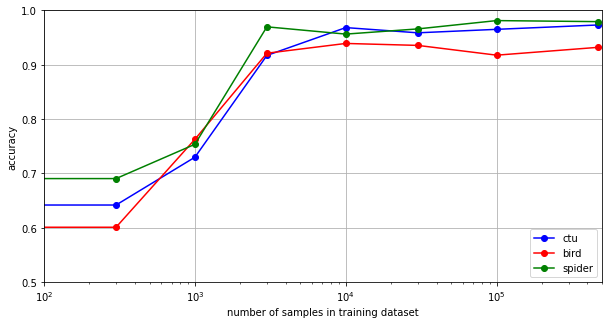

In [46]:
import matplotlib.pyplot as plt

x = [int(dataset_size) for dataset_size in dataset_sizes]

# accuracy for "ctu", "bird", "spider" datasets
y_ctu = list(accuracy_by_dataset_by_dataset_sizes["ctu"].values())
y_bird = list(accuracy_by_dataset_by_dataset_sizes["bird"].values())
y_spider = list(accuracy_by_dataset_by_dataset_sizes["spider"].values())

plt.figure(figsize=(10,5))

plt.semilogx(x, y_ctu, marker="o", color="blue", label="ctu")
plt.semilogx(x, y_bird, marker="o", color="red", label="bird")
plt.semilogx(x, y_spider, marker="o", color="green", label="spider")

plt.xlim([100, 500000])
plt.ylim([0.5, 1])

# Continued from earlier code 
plt.xlabel("number of samples in training dataset")
plt.ylabel("accuracy")
plt.grid(True)

# Add a legend to the plot
plt.legend(loc='lower right')

plt.show()